# Application of Fourier Flows to Synthetic Data

In this notebook, we reproduce the first experiment (Section 5.1) in our paper "Generative Time-series Modeling with Fourier Flows" published in ICLR 2021 by Ahmed M. Alaa, Alex Chan and Mihaela van der Schaar. 

In [1]:
from data.synthetic import sine_data_generation
from utils.spectral import get_frequencies, power_spectral_density
from SequentialFlows import FourierFlow, RealNVP
from models.sequential import RNNmodel
from models.timegan import timegan

import os
import random

import numpy as np
import torch
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
tf.random.set_random_seed(1234)
random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# TF logging:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)

### Sampling synthetic data

Here we consider the following time-series data generation process:

$x = \sin(ft + \phi),$ $\phi \sim \mathcal{N}(0,1)$, $f \sim Beta(\alpha, \beta), t \in \{0, \ldots, T-1\}$

In [4]:
T           = 101
n_samples   = 1000
X           = sine_data_generation(no=n_samples, seq_len=T, dim=1)

### Fitting the Fourier Flows and Real-NVP models

Imported from "SequentialFlows"

In [5]:
FF_model    = FourierFlow(hidden=200, fft_size=T, n_flows=10, normalize=False)
RVP_model   = RealNVP(hidden=200, T=T, n_flows=10) 

In [6]:
FF_losses   = FF_model.fit(X, epochs=1000, batch_size=128, 
                           learning_rate=1e-3, display_step=100)

step: 0 	/ 1000 	----------	loss: 128.966
step: 100 	/ 1000 	|---------	loss: -396.748
step: 200 	/ 1000 	||--------	loss: -467.169
step: 300 	/ 1000 	|||-------	loss: -473.703
step: 400 	/ 1000 	||||------	loss: -542.593
step: 500 	/ 1000 	|||||-----	loss: -566.997
step: 600 	/ 1000 	||||||----	loss: -597.534
step: 700 	/ 1000 	|||||||---	loss: -566.878
step: 800 	/ 1000 	||||||||--	loss: -607.090
step: 900 	/ 1000 	|||||||||-	loss: -640.931
step: 999 	/ 1000 	||||||||||	loss: -636.307
Finished training!


In [7]:
RVP_losses  = RVP_model.fit(X, epochs=1000, batch_size=128, 
                            learning_rate=1e-3, display_step=100)

step: 0 	/ 1000 	----------	loss: 194.081
step: 100 	/ 1000 	|---------	loss: 101.665
step: 200 	/ 1000 	||--------	loss: 86.574
step: 300 	/ 1000 	|||-------	loss: 51.666
step: 400 	/ 1000 	||||------	loss: 26.569
step: 500 	/ 1000 	|||||-----	loss: -4.609
step: 600 	/ 1000 	||||||----	loss: -7.381
step: 700 	/ 1000 	|||||||---	loss: -50.942
step: 800 	/ 1000 	||||||||--	loss: -62.359
step: 900 	/ 1000 	|||||||||-	loss: -68.475
step: 999 	/ 1000 	||||||||||	loss: -85.919
Finished training!


### Sample from Fourier flows and Real-NVP models

In [8]:
X_gen_FF   = FF_model.sample(1000)
X_gen_RVP  = RVP_model.sample(1000)

### Fitting and sampling from TimeGAN model

In [9]:
X_                   = [X[k].reshape((-1, 1)) for k in range(len(X))]
X_gen_TGAN           = timegan(X_, dict({'module': 'gru', 'hidden_dim': 24, 'num_layer': 3, 'iterations': 500, 'batch_size': 128}))

Start Embedding Network Training
step: 0/500, e_loss: 0.3597
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/500, s_loss: 0.229
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/500, d_loss: 2.0919, g_loss_u: 0.6559, g_loss_s: 0.037, g_loss_v: 0.3831, e_loss_t0: 0.191
Finish Joint Training


### Fitting predictive RNN models

We evaluate the accuracy of the sampled data in the time-domain by assessing their predictive usefulness as follows: we trained a vanilla RNN model using each of the three synthetically generated samples to sequentially predict the next value in each time series in the original data. We then evaluate the MAE of the three RNN models across all time steps.

#### Instantiate RNN models and prepare labeled sequential data

In [10]:
predictive_model_TGAN    = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)
predictive_model_RealNVP = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)
predictive_model_FF      = RNNmodel(HIDDEN_UNITS=100, NUM_LAYERS=2, MAX_STEPS=100, INPUT_SIZE=1)

X_FF                     = [X_gen_FF[k][:len(X_gen_FF[k])-1] for k in range(len(X_gen_FF))]
Y_FF                     = [X_gen_FF[k][1:] for k in range(len(X_gen_FF))]

X_RealNVP                = [X_gen_RVP [k][:len(X_gen_RVP [k])-1] for k in range(len(X_gen_RVP ))]
Y_RealNVP                = [X_gen_RVP [k][1:] for k in range(len(X_gen_RVP ))]

X_TGAN                   = [X_gen_TGAN[k][:len(X_gen_TGAN[k])-1] for k in range(len(X_gen_TGAN))]
Y_TGAN                   = [X_gen_TGAN[k][1:] for k in range(len(X_gen_TGAN))]

#### Fit the three RNN models, each on a synthetic data set generated by a different baseline

In [11]:
predictive_model_FF.fit(X_FF, Y_FF)
predictive_model_RealNVP.fit(X_RealNVP, Y_RealNVP)
predictive_model_TGAN.fit(X_TGAN, Y_TGAN)

Epoch:  0 | train loss: 3.2041
Epoch:  1 | train loss: 0.2511
Epoch:  2 | train loss: 0.0413
Epoch:  3 | train loss: 0.0650
Epoch:  4 | train loss: 0.0328
Epoch:  0 | train loss: 0.2530
Epoch:  1 | train loss: 0.2134
Epoch:  2 | train loss: 0.2002
Epoch:  3 | train loss: 0.2047
Epoch:  4 | train loss: 0.2081
Epoch:  0 | train loss: 0.4792
Epoch:  1 | train loss: 0.0524
Epoch:  2 | train loss: 0.0398
Epoch:  3 | train loss: 0.0392
Epoch:  4 | train loss: 0.0327


### Visualizing the results

#### Reconstruction of Figure 2(a). 

The three figures below demonstrate the spectral components of a sample from each of the three models. Each sample will have a slightly different spectrum at each run. On average, the TimeGAN model tends to "memorize" the real data. This manifest in the support of the estimated spectral density in one of two ways. The model either concentrates the probability mass on the frequency components observed in the real data (as in the sample illustrated in the paper), or covers a wider support including higher and lower frequencies than the ones observed based on outliers in the data.

<AxesSubplot:ylabel='Density'>

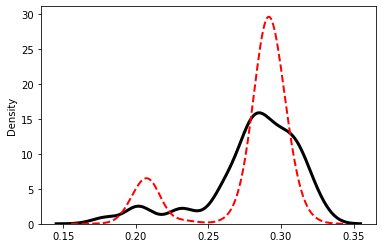

In [12]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_FF), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

<AxesSubplot:ylabel='Density'>

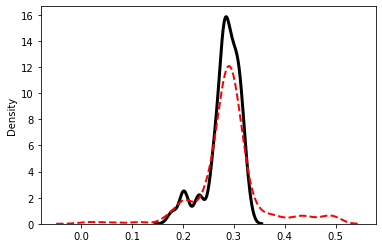

In [13]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_RVP), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

<AxesSubplot:ylabel='Density'>

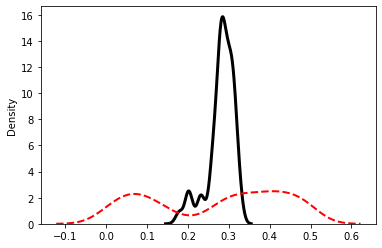

In [14]:
sns.distplot(get_frequencies(X), hist=False, color="black", kde_kws={'linewidth':3})
sns.distplot(get_frequencies(X_gen_TGAN), hist=False, color="red", kde_kws={'linestyle':'--', 'linewidth':2})

#### Reconstruction of Figure 2(b). 

Learning curves, accuracy of the recovered spectra and accuracy of RNN models trained on synthetic data. 

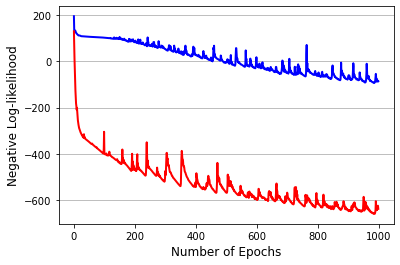

In [15]:
plt.plot(RVP_losses, linewidth=2, color="b")
plt.plot(FF_losses, linewidth=2, color="r")

plt.xlabel("Number of Epochs", fontsize=12)
plt.ylabel("Negative Log-likelihood", fontsize=12)

plt.grid(axis="y")

In [16]:
FF_PSD_Errors      = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_FF))[:100]
RealNVP_PSD_Errors = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_RVP))[:100]
TGAN_PSD_Errors    = np.abs(power_spectral_density(X)-power_spectral_density(X_gen_TGAN.reshape((1000, 101))))[:100]

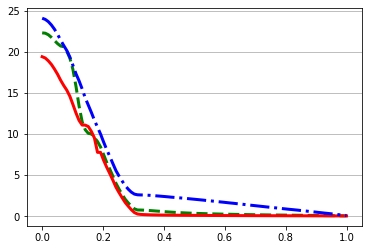

In [17]:
freqs              = np.linspace(0, 1, 100)

plt.plot(freqs, np.cumsum(TGAN_PSD_Errors)[::-1], linewidth=3, color="g", linestyle="--")
plt.plot(freqs, np.cumsum(FF_PSD_Errors)[::-1], linewidth=3, color="r")
plt.plot(freqs, np.cumsum(RealNVP_PSD_Errors)[::-1], linewidth=3, color="b", linestyle="-.")

plt.grid(axis="y")

In [18]:
# ---

In [19]:
X_true                  = [X[k][:len(X[k])-1] for k in range(len(X))]
Y_true                  = [X[k][1:] for k in range(len(X))]

X_TGAN_pred             = predictive_model_TGAN.predict(X_true)
X_FF_pred               = predictive_model_FF.predict(X_true)
X_RealNVP_pred          = predictive_model_RealNVP.predict(X_true)

In [20]:
TGAN_RNN_errs    = np.mean(np.abs(np.array(X_TGAN_pred) - np.array(Y_true)), axis=0)
FF_RNN_errs      = np.mean(np.abs(np.array(X_FF_pred) - np.array(Y_true)), axis=0)
RealNVP_RNN_errs = np.mean(np.abs(np.array(X_RealNVP_pred) - np.array(Y_true)), axis=0)

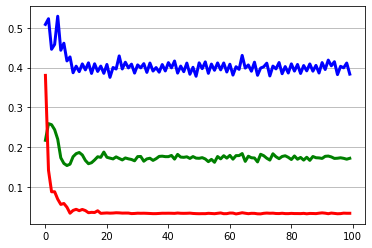

In [21]:
plt.plot(TGAN_RNN_errs, linewidth=3, color="g")
plt.plot(FF_RNN_errs, linewidth=3, color="r")
plt.plot(RealNVP_RNN_errs, linewidth=3, color="b")

plt.grid(axis="y")